## Libraries

In [94]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing
import re
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [95]:
# Any results you write to the current directory are saved as output.
# busdata=pd.read_csv(r"C:\Users\ihamm\Downloads\Compressed\archive_2\Bus_Breakdown_and_Delays.csv")
busdata=pd.read_csv(r"C:\Users\ihamm\Downloads\bus-breakdown-and-delays-1.csv")
busdata.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,11/05/2015 08:10:00 AM,11/05/2015 08:12:00 AM,New Jersey,...,NaN,11,Yes,No,Yes,11/05/2015 08:12:00 AM,NaN,11/05/2015 08:12:14 AM,Running Late,School-Age
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,11/05/2015 08:10:00 AM,11/05/2015 08:12:00 AM,Manhattan,...,20MNS,2,Yes,Yes,No,11/05/2015 08:12:00 AM,NaN,11/05/2015 08:13:34 AM,Running Late,School-Age
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,11/05/2015 08:09:00 AM,11/05/2015 08:13:00 AM,Bronx,...,15MIN,8,Yes,Yes,Yes,11/05/2015 08:13:00 AM,NaN,11/05/2015 08:13:22 AM,Running Late,Pre-K
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,11/05/2015 08:12:00 AM,11/05/2015 08:14:00 AM,Manhattan,...,15 MIN,6,No,No,No,11/05/2015 08:14:00 AM,NaN,11/05/2015 08:14:04 AM,Running Late,School-Age
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,11/05/2015 08:13:00 AM,11/05/2015 08:14:00 AM,Manhattan,...,NaN,6,No,No,No,11/05/2015 08:14:00 AM,NaN,11/05/2015 08:14:08 AM,Running Late,School-Age


# Preprocessing

In [96]:
#String Conditions
busdata['How_Long_Delayed'] = busdata['How_Long_Delayed'].astype(str)
# Define a condition to filter rows where 'How_Long_Delayed' is equal to 'Route_Number'
bus_no_condition = busdata['How_Long_Delayed'] == busdata['Bus_No']

# Define a condition to filter rows with time values
time_condition = busdata['How_Long_Delayed'].str.contains(r'\b\d{1,2}:\d{2}\s*(?:am|pm|AM|PM)?\b', regex=True)

# Define a condition to filter rows with a question mark ('?')
question_mark_condition = busdata['How_Long_Delayed'].str.contains(r'\?')

# Combine all conditions using logical OR (|) to drop rows that meet any of the conditions
combined_condition = bus_no_condition | time_condition | question_mark_condition

# Define a function to convert time expressions to minutes
def convert_to_minutes(time_str):
    # Dictionary mapping common variations to minutes
    variations_to_minutes = {
        '1 1/2 HOUR': 90,
        '1 1/2 HR': 90,
        '1 H': 60,
        '1 HOUIR': 60,
        '1 hour': 60,
        '1 hour 15': 75,
        '1 HOUR 15M': 75,
        '1 hour lat': 60,  # Modify as needed
        '1 HOUR?': 60,     # Modify as needed
        '1 HOUR1/2': 90,
        '1 hourhalf': 60,  # Modify as needed
        '1 hourr': 60,     # Modify as needed
        '1 HOURS': 60,
        '1 HR': 60,
        '1 hr 15': 75,
        '1 hr 15min': 75,
        '1 hr 30': 90,
        '1 HR 30 MI': 90,
        '1 hr 30min': 90,
        '1 HR.': 60,
        '1 HR+': 60,       # Modify as needed
        '1 HRS': 60,
        '1.5 hour': 90,
        '1.5 HRS': 90,
        '1/2 HOUR': 30,
        '1/2 HOUR?': 30,   # Modify as needed
        '1/2 hr': 30,
        '1/2hour': 30,
        '1:00 h': 60,
        '1:00 hour': 60,
        '1:30 h': 90,
        '1:30 H/': 90,
        '1:30 HR': 90,
        '1:45hr': 105,
        '1:hr': 60,
        '1H': 60,
        '1H15MIN': 75,
        '1ho': 60,
        '1HOIUR': 60,
        '1hour': 60,
        '1-HOUR': 60,
        '1hour 20mi': 80,  # Modify as needed
        '1hour 30mi': 90,  # Modify as needed
        '1HOUR15MIN': 75,
        '1hour45min': 105,
        '1-HOURS': 60,
        '1hr': 60,
        '1hr - 1:45': 105,
        '1hr - 11/2': 90,
        '1hr /30min': 90,  # Modify as needed
        '1HR +': 60,       # Modify as needed
        '1hr 10mins': 70,  # Modify as needed
        '1hr 15mins': 75,
        '1hr 20 min': 80,
        '1hr 20mins': 80,
        '1HR 30 MIN': 90,
        '1hr 30min': 90,
        '1hr 30mins': 90,
        '1hr 40 min': 100,
        '1HR 45 MIN': 105,
        '1hr 45min': 105,
        '1hr 45mins': 105,
        '1hr late': 60,    # Modify as needed
        '1hr&30min': 90,
        '1hr. 20 mi': 80,
        '1hr/????mi': 60,  # Modify as needed
        '1hr/15min': 75,
        '1hr/1hr 30': 90,  # Modify as needed
        '1hr/20min': 80,
        '1hr/30min': 90,
        '1hr/30min?': 90,
        '1hr??': 60,       # Modify as needed
        '1hr???': 60,      # Modify as needed
        '1hr????': 60,     # Modify as needed
        '1hr?????': 60,    # Modify as needed
        '1HR++': 60,       # Modify as needed
        '1hr-1 1/2': 90,
        '1hr20 mins': 80,  # Modify as needed
        '1HR20MIN': 80,
        '1hr45min': 105,
        '1HRS': 60,
        '1hrs 20mnt': 80,  # Modify as needed
        '2 HOUR': 120,
        '2 HOURS': 120,
        '2 HOURS TR': 120, # Modify as needed
        '2 hr': 120,
        '2 HRS': 120,
        '2 HRS.': 120,     # Modify as needed
        '2.0 HRS': 120,
        '2:hr': 120,
        '2:HRS': 120,
        '2hours': 120,
        '2hr': 120,
        '2HRS': 120,
        '3 HOUR': 180,
        '3 hr': 180,
        '3 HRS': 180,
        '30hour': 1800,    # Modify as needed
        '30hr': 1800,      # Modify as needed
        '30MINS-1HR': 60,  # Modify as needed
        '4 hours': 240,
        '4 hrs': 240,
        '40/1HR': 60,      # Modify as needed
        '40-1 hour': 60,   # Modify as needed
        '40-1hr': 60,      # Modify as needed
        '45 -1 hour': 60,
        '45 -1hour': 60,
        '45 MIN/1HR': 60,
        '45 min-1 h': 60,
        '45 min-1hr': 60,
        '45/1hour': 60,
        '45/1HR': 60,
        '45-1 HR': 60,
        '45-1hour': 60,
        '451HR': 60,
        '45-1hr': 60,
        '45HR': 60,
        '45min - 1h': 60,
        '45min -1hr': 60,
        '45min/1hr': 60,
        '45min-1 hr': 60,
        '45min-1hr': 60,
        '45mini/1hr': 60,
        '45mins 1hr': 60,
        '45minTO 1H': 60,
        '50-1 hour': 60,
        '50-1HR': 60,
        '50min 1hr': 60,
        'half hour': 30,
        'HOUR': 60,
        'HR1': 60,
        'IHR40MIN': 100,   # Modify as needed
        'MORE THAN': None,  # Modify as needed
        'ONE HOUR': 60
    }

    # Check if the time_str matches any variation, and return the corresponding value
    return variations_to_minutes.get(time_str, time_str)

def extract_delay_minutes(delay_str):
    try:
        # Use regular expression to extract numeric values
        minutes_match = re.search(r'\b(\d+)\b', str(delay_str).lower())
        if minutes_match:
            return int(minutes_match.group())
    except:
        return None

busdata['How_Long_Delayed'] = busdata['How_Long_Delayed'].apply(convert_to_minutes)

busdata['How_Long_Delayed'] = busdata['How_Long_Delayed'].astype(str)
ls=[]
for x in busdata['How_Long_Delayed']:
    ls.append(re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", x))
busdata['How_Long_Delayed'] = ls

# Applying the functions to the 'How_Long_Delayed' column

busdata['How_Long_Delayed'] = busdata['How_Long_Delayed'].apply(extract_delay_minutes)

# Drop rows based on the combined condition
busdata.drop(busdata[combined_condition].index, inplace=True)

busdata['How_Long_Delayed'] = busdata['How_Long_Delayed'].fillna(0).astype(int).replace(0, busdata['How_Long_Delayed'].mean())

value_condition = (busdata['How_Long_Delayed'] > 480) | (busdata['How_Long_Delayed'] < 0)
busdata.drop(busdata[value_condition].index,inplace=True)

# # Resetting the index after dropping rows
busdata.reset_index(drop=True, inplace=True)
busdata['How_Long_Delayed'] = busdata['How_Long_Delayed'].astype(int)
# Print the updated DataFrame
busdata['How_Long_Delayed']

0         27
1         20
2         15
3         15
4         27
          ..
280415    15
280416    20
280417    20
280418    27
280419    45
Name: How_Long_Delayed, Length: 280420, dtype: int32

In [97]:
busdata

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,11/05/2015 08:10:00 AM,11/05/2015 08:12:00 AM,New Jersey,...,27,11,Yes,No,Yes,11/05/2015 08:12:00 AM,NaN,11/05/2015 08:12:14 AM,Running Late,School-Age
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,11/05/2015 08:10:00 AM,11/05/2015 08:12:00 AM,Manhattan,...,20,2,Yes,Yes,No,11/05/2015 08:12:00 AM,NaN,11/05/2015 08:13:34 AM,Running Late,School-Age
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,11/05/2015 08:09:00 AM,11/05/2015 08:13:00 AM,Bronx,...,15,8,Yes,Yes,Yes,11/05/2015 08:13:00 AM,NaN,11/05/2015 08:13:22 AM,Running Late,Pre-K
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,11/05/2015 08:12:00 AM,11/05/2015 08:14:00 AM,Manhattan,...,15,6,No,No,No,11/05/2015 08:14:00 AM,NaN,11/05/2015 08:14:04 AM,Running Late,School-Age
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,11/05/2015 08:13:00 AM,11/05/2015 08:14:00 AM,Manhattan,...,27,6,No,No,No,11/05/2015 08:14:00 AM,NaN,11/05/2015 08:14:08 AM,Running Late,School-Age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280415,2016-2017,1338452,Pre-K/EI,9345,2,Heavy Traffic,C530,04/05/2017 08:00:00 AM,04/05/2017 08:10:00 AM,Bronx,...,15,7,Yes,Yes,No,04/05/2017 08:10:00 AM,NaN,04/05/2017 08:10:15 AM,Running Late,Pre-K
280416,2016-2017,1341521,Pre-K/EI,0001,5,Heavy Traffic,C579,04/24/2017 07:42:00 AM,04/24/2017 07:44:00 AM,Bronx,...,20,0,Yes,Yes,No,04/24/2017 07:44:00 AM,NaN,04/24/2017 07:44:15 AM,Running Late,Pre-K
280417,2016-2017,1353044,Special Ed PM Run,GC0112,X928,Heavy Traffic,09003,05/25/2017 04:22:00 PM,05/25/2017 04:28:00 PM,Bronx,...,20,0,Yes,Yes,Yes,05/25/2017 04:28:00 PM,90323827,05/25/2017 04:34:36 PM,Running Late,School-Age
280418,2016-2017,1353045,Special Ed PM Run,5525D,Q920,Won`t Start,24457,05/25/2017 04:27:00 PM,05/25/2017 04:30:00 PM,Queens,...,27,0,Yes,Yes,No,05/25/2017 04:30:00 PM,NaN,05/25/2017 04:30:07 PM,Breakdown,School-Age


## Exploratory Data Analysis

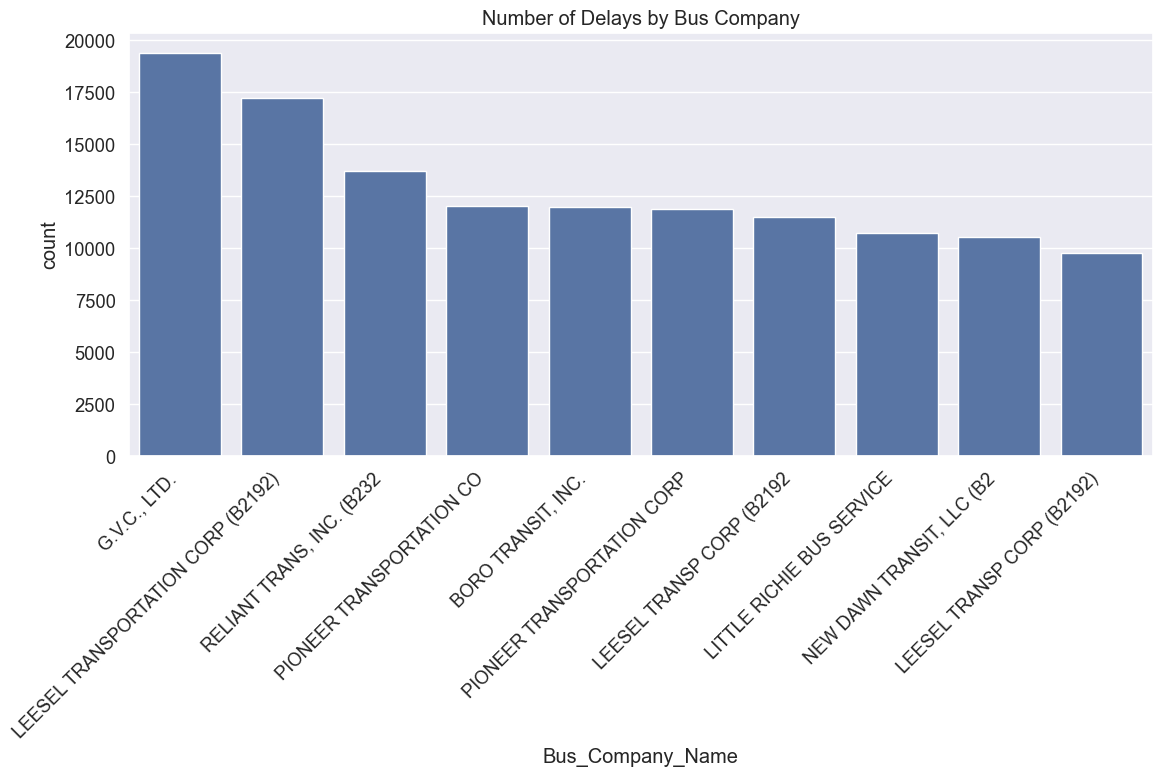

In [98]:
# Which bus company has the highest number of delays:
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.countplot(x='Bus_Company_Name', data=busdata, order=busdata['Bus_Company_Name'].value_counts().head(10).index)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Delays by Bus Company')
plt.tight_layout()  # Adjust layout to avoid cutting off the image
plt.savefig('Number of Delays by Bus Company.png', dpi=300) 
plt.show()

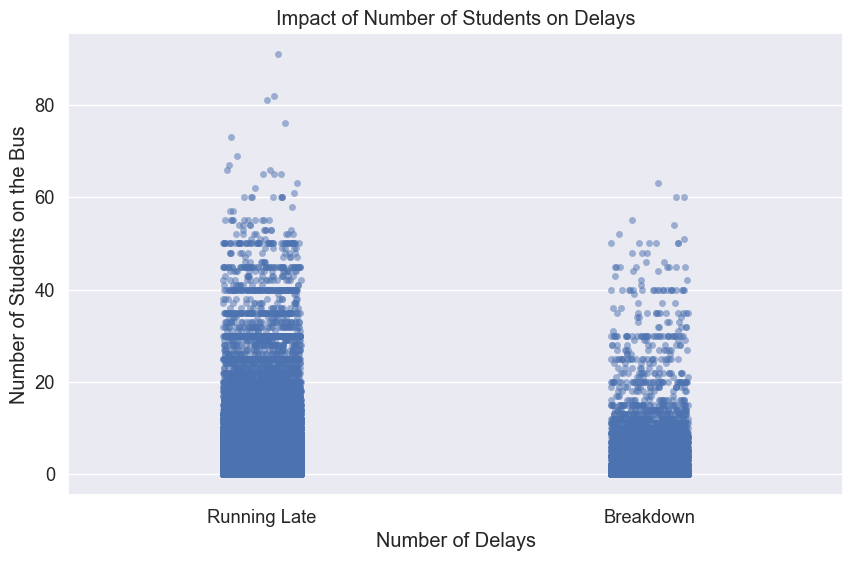

In [99]:
# # Does the number of students impact the number of delays:
# plt.figure(figsize=(10, 6))
# sns.lineplot(x='Breakdown_or_Running_Late', y='Number_Of_Students_On_The_Bus', data=busdata, alpha=0.5)
# plt.xlabel('Number of Delays')
# plt.ylabel('Number of Students on the Bus')

# plt.title('Impact of Number of Students on Delays')
# plt.show()

filtered_busdata = busdata[busdata['Number_Of_Students_On_The_Bus'] <= 100]

plt.figure(figsize=(10, 6))
sns.stripplot(x='Breakdown_or_Running_Late', y='Number_Of_Students_On_The_Bus', data=filtered_busdata, jitter=True, alpha=0.5)
plt.xlabel('Number of Delays')
plt.ylabel('Number of Students on the Bus')
plt.title('Impact of Number of Students on Delays')
plt.savefig('Impact of Number of Students on Delays.png', dpi=300) 
plt.show()

In [100]:
# # Calculate the correlation coefficient
# correlation = busdata['Breakdown_or_Running_Late'].corr(busdata['Number_Of_Students_On_The_Bus'])

# # Print the correlation coefficient
# print(f"Correlation between Number of Delays and Number of Students on the Bus: {correlation}")

# # Create a scatter plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Breakdown_or_Running_Late', y='Number_Of_Students_On_The_Bus', data=busdata, alpha=0.5)
# plt.xlabel('Number of Delays')
# plt.ylabel('Number of Students on the Bus')
# plt.title('Impact of Number of Students on Delays')
# plt.show()

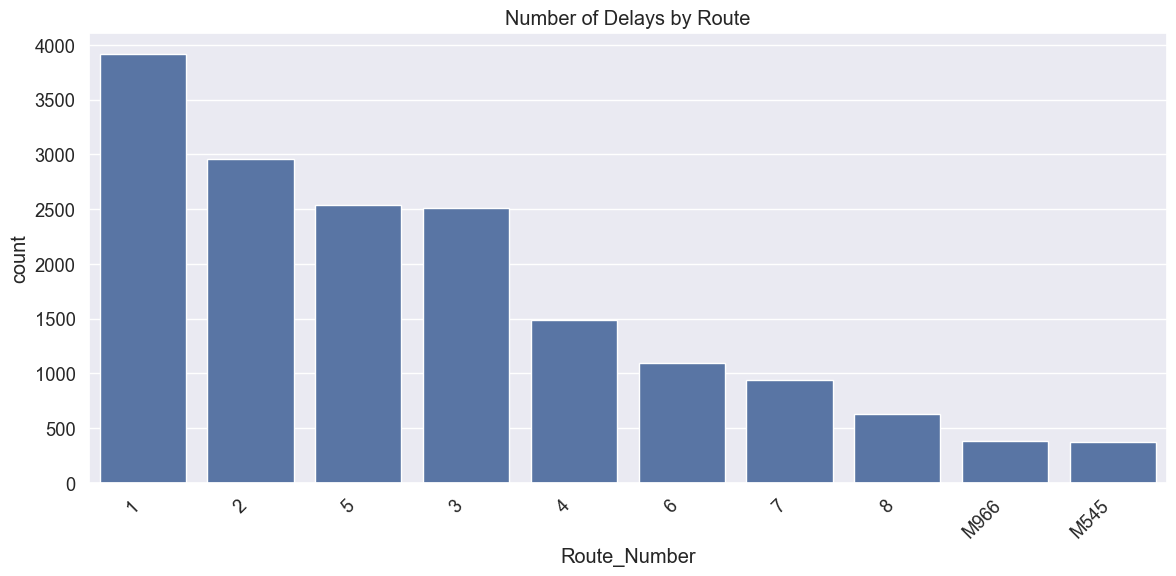

In [102]:
# Which route has the most delays:
plt.figure(figsize=(12, 6))
sns.countplot(x='Route_Number', data=busdata, order=busdata['Route_Number'].value_counts().head(10).index)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Delays by Route')
plt.tight_layout()
plt.savefig('Number of Delays by Route.png', dpi=300) 
plt.show()

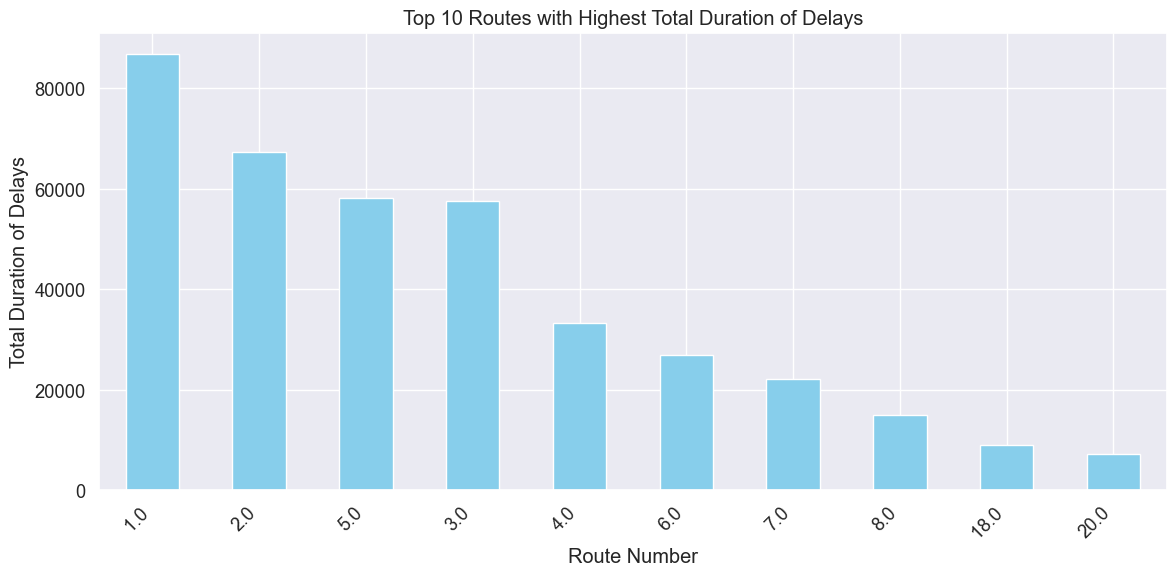

In [103]:
# Does the route impact the duration of the delay:
# Convert 'Route_Number' and 'How_Long_Delayed' to numeric, handling errors
busdata['Route_Number'] = pd.to_numeric(busdata['Route_Number'], errors='coerce')
busdata['How_Long_Delayed'] = pd.to_numeric(busdata['How_Long_Delayed'], errors='coerce')
# Calculate the total duration of delays by route and get the top 10 routes
top_routes = busdata.groupby('Route_Number')['How_Long_Delayed'].sum().nlargest(10)

# Plotting the top 10 routes and their total duration of delays
plt.figure(figsize=(12, 6))
top_routes.plot(kind='bar', color='skyblue')
plt.xlabel('Route Number')
plt.ylabel('Total Duration of Delays')
plt.title('Top 10 Routes with Highest Total Duration of Delays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Top 10 Routes with Highest Total Duration of Delays.png', dpi=300) 
plt.show()

## Adding more features (data & time)

In [55]:


busdata['Occurred_On'] = pd.to_datetime(busdata['Occurred_On'])
busdata['Created_On'] = pd.to_datetime(busdata['Created_On'])
busdata['Informed_On'] = pd.to_datetime(busdata['Informed_On'])
busdata['Last_Updated_On'] = pd.to_datetime(busdata['Last_Updated_On'])

# Extract features from datetime columns
busdata['Occurred_Year'] = busdata['Occurred_On'].dt.year
busdata['Occurred_Month'] = busdata['Occurred_On'].dt.month
busdata['Occurred_Day'] = busdata['Occurred_On'].dt.day
busdata['Occurred_Hour'] = busdata['Occurred_On'].dt.hour
busdata['Occurred_Weekday'] = busdata['Occurred_On'].dt.weekday  # Monday=0, Sunday=6

busdata['Created_Year'] = busdata['Created_On'].dt.year
busdata['Created_Month'] = busdata['Created_On'].dt.month
busdata['Created_Day'] = busdata['Created_On'].dt.day
busdata['Created_Hour'] = busdata['Created_On'].dt.hour
busdata['Created_Weekday'] = busdata['Created_On'].dt.weekday

busdata['Informed_Year'] = busdata['Informed_On'].dt.year
busdata['Informed_Month'] = busdata['Informed_On'].dt.month
busdata['Informed_Day'] = busdata['Informed_On'].dt.day
busdata['Informed_Hour'] = busdata['Informed_On'].dt.hour
busdata['Informed_Weekday'] = busdata['Informed_On'].dt.weekday

busdata['Last_Updated_Year'] = busdata['Last_Updated_On'].dt.year
busdata['Last_Updated_Month'] = busdata['Last_Updated_On'].dt.month
busdata['Last_Updated_Day'] = busdata['Last_Updated_On'].dt.day
busdata['Last_Updated_Hour'] = busdata['Last_Updated_On'].dt.hour
busdata['Last_Updated_Weekday'] = busdata['Last_Updated_On'].dt.weekday

In [56]:
le=preprocessing.LabelEncoder()
le.fit(busdata['Breakdown_or_Running_Late'])
busdata['Breakdown_or_Running_Late']=le.transform(busdata['Breakdown_or_Running_Late'])
le.fit(busdata['Has_Contractor_Notified_Parents'])
busdata['Has_Contractor_Notified_Parents']=le.transform(busdata['Has_Contractor_Notified_Parents'])
le.fit(busdata['Have_You_Alerted_OPT'])
busdata['Have_You_Alerted_OPT']=le.transform(busdata['Have_You_Alerted_OPT'])
le.fit(busdata['Reason'])
busdata['Reason']=le.transform(busdata['Reason'])
le.fit(busdata['Has_Contractor_Notified_Schools'])
busdata['Has_Contractor_Notified_Schools']=le.transform(busdata['Has_Contractor_Notified_Schools'])
le.fit(busdata['School_Age_or_PreK'])
busdata['School_Age_or_PreK']=le.transform(busdata['School_Age_or_PreK'])
le.fit(busdata['Schools_Serviced'])
busdata['Schools_Serviced']=le.transform(busdata['Schools_Serviced'])
le.fit(busdata['Bus_Company_Name'])
busdata['Bus_Company_Name']=le.transform(busdata['Bus_Company_Name'])
le.fit(busdata['Bus_No'])
busdata['Bus_No']=le.transform(busdata['Bus_No'])
le.fit(busdata['Route_Number'])
busdata['Route_Number']=le.transform(busdata['Route_Number'])
le.fit(busdata['Boro'])
busdata['Boro']=le.transform(busdata['Boro'])
busdata.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Informed_Year,Informed_Month,Informed_Day,Informed_Hour,Informed_Weekday,Last_Updated_Year,Last_Updated_Month,Last_Updated_Day,Last_Updated_Hour,Last_Updated_Weekday
0,2015-2016,1227538,Special Ed AM Run,4396,125,3,15133,2015-11-05 08:10:00,2015-11-05 08:12:00,6,...,2015,11,5,8,3,2015,11,5,8,3
1,2015-2016,1227539,Special Ed AM Run,1404,125,3,2889,2015-11-05 08:10:00,2015-11-05 08:12:00,4,...,2015,11,5,8,3,2015,11,5,8,3
2,2015-2016,1227540,Pre-K/EI,6070,3,3,15340,2015-11-05 08:09:00,2015-11-05 08:13:00,1,...,2015,11,5,8,3,2015,11,5,8,3
3,2015-2016,1227541,Special Ed AM Run,6540,125,3,1248,2015-11-05 08:12:00,2015-11-05 08:14:00,4,...,2015,11,5,8,3,2015,11,5,8,3
4,2015-2016,1227542,Special Ed AM Run,5280,125,3,662,2015-11-05 08:13:00,2015-11-05 08:14:00,4,...,2015,11,5,8,3,2015,11,5,8,3


In [57]:
busdata.tail()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Informed_Year,Informed_Month,Informed_Day,Informed_Hour,Informed_Weekday,Last_Updated_Year,Last_Updated_Month,Last_Updated_Day,Last_Updated_Hour,Last_Updated_Weekday
280415,2016-2017,1338452,Pre-K/EI,10246,2,3,15363,2017-04-05 08:00:00,2017-04-05 08:10:00,1,...,2017,4,5,8,2,2017,4,5,8,2
280416,2016-2017,1341521,Pre-K/EI,20,6,3,15380,2017-04-24 07:42:00,2017-04-24 07:44:00,1,...,2017,4,24,7,0,2017,4,24,7,0
280417,2016-2017,1353044,Special Ed PM Run,10870,125,3,4027,2017-05-25 16:22:00,2017-05-25 16:28:00,1,...,2017,5,25,16,3,2017,5,25,16,3
280418,2016-2017,1353045,Special Ed PM Run,7540,125,9,11934,2017-05-25 16:27:00,2017-05-25 16:30:00,7,...,2017,5,25,16,3,2017,5,25,16,3
280419,2016-2017,1353046,Project Read PM Run,4172,125,6,10400,2017-05-25 16:36:00,2017-05-25 16:37:00,2,...,2017,5,25,16,3,2017,5,25,16,3


In [58]:
#Dropping columns which are less significant from judgement
busdata_clean=busdata.drop(['School_Year','Busbreakdown_ID','Run_Type','Incident_Number','Occurred_On','Created_On','Informed_On','Last_Updated_On'],axis=1)

In [59]:
busdata_clean.head()

,Bus_No,Route_Number,Reason,Schools_Serviced,Boro,Bus_Company_Name,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,...,Informed_Year,Informed_Month,Informed_Day,Informed_Hour,Informed_Weekday,Last_Updated_Year,Last_Updated_Month,Last_Updated_Day,Last_Updated_Hour,Last_Updated_Weekday
0,4396,125,3,15133,6,86,27,11,1,0,...,2015,11,5,8,3,2015,11,5,8,3
1,1404,125,3,2889,4,41,20,2,1,1,...,2015,11,5,8,3,2015,11,5,8,3
2,6070,3,3,15340,1,37,15,8,1,1,...,2015,11,5,8,3,2015,11,5,8,3
3,6540,125,3,1248,4,86,15,6,0,0,...,2015,11,5,8,3,2015,11,5,8,3
4,5280,125,3,662,4,86,27,6,0,0,...,2015,11,5,8,3,2015,11,5,8,3


In [60]:
#Function for float or int conversion
def int_or_float(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

In [61]:
#Converting the data type for columns to keep them int / float instead of string for tree model
list_column=pd.DataFrame()
def convertDataType(df):
    tempCol=[]
    for k,v in df[0:len(df)].items():
        for eachVal in range(len(df[0:len(df)])):
            if(type(v[eachVal]) != float):
                tempCol.append(int_or_float(v[eachVal]))
        list_column[k]=tempCol
        tempCol=[]
    #return list_column

In [62]:
convertDataType(busdata_clean)
list_column.head()

,Bus_No,Route_Number,Reason,Schools_Serviced,Boro,Bus_Company_Name,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,...,Informed_Year,Informed_Month,Informed_Day,Informed_Hour,Informed_Weekday,Last_Updated_Year,Last_Updated_Month,Last_Updated_Day,Last_Updated_Hour,Last_Updated_Weekday
0,4396,125,3,15133,6,86,27,11,1,0,...,2015,11,5,8,3,2015,11,5,8,3
1,1404,125,3,2889,4,41,20,2,1,1,...,2015,11,5,8,3,2015,11,5,8,3
2,6070,3,3,15340,1,37,15,8,1,1,...,2015,11,5,8,3,2015,11,5,8,3
3,6540,125,3,1248,4,86,15,6,0,0,...,2015,11,5,8,3,2015,11,5,8,3
4,5280,125,3,662,4,86,27,6,0,0,...,2015,11,5,8,3,2015,11,5,8,3


In [63]:
#Now we have the data cleaned for a model
list_column.columns

Index(['Bus_No', 'Route_Number', 'Reason', 'Schools_Serviced', 'Boro',
       'Bus_Company_Name', 'How_Long_Delayed', 'Number_Of_Students_On_The_Bus',
       'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents',
       'Have_You_Alerted_OPT', 'Breakdown_or_Running_Late',
       'School_Age_or_PreK', 'Occurred_Year', 'Occurred_Month', 'Occurred_Day',
       'Occurred_Hour', 'Occurred_Weekday', 'Created_Year', 'Created_Month',
       'Created_Day', 'Created_Hour', 'Created_Weekday', 'Informed_Year',
       'Informed_Month', 'Informed_Day', 'Informed_Hour', 'Informed_Weekday',
       'Last_Updated_Year', 'Last_Updated_Month', 'Last_Updated_Day',
       'Last_Updated_Hour', 'Last_Updated_Weekday'],
      dtype='object')

In [64]:
# Check for duplicates
duplicates = list_column.duplicated()

# Print if there are any duplicates
if duplicates.any():
    print("There are duplicate rows between training and testing sets-Removing.")
    list_column.drop_duplicates(inplace=True)
else:
    print("No duplicate rows found between training and testing sets.")

There are duplicate rows between training and testing sets-Removing.


In [65]:
X=list_column.drop(['Breakdown_or_Running_Late'],axis=1)
y=list_column['Breakdown_or_Running_Late']
#Creating the training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SMOTE 

In [66]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [67]:
# Combine balanced training data and the corresponding labels
X_train_balanced_df = pd.concat([pd.DataFrame(X_train_balanced), pd.Series(y_train_balanced)], axis=1)

# Check for duplicates before removing
print("Number of duplicates before removing:", X_train_balanced_df.duplicated().sum())

# Remove duplicates
X_train_balanced_df_no_duplicates = X_train_balanced_df.drop_duplicates()

# Check for duplicates after removing
print("Number of duplicates after removing:", X_train_balanced_df_no_duplicates.duplicated().sum())

# Separate features and labels after removing duplicates
X_train_balanced_cleaned = X_train_balanced_df_no_duplicates.iloc[:, :-1]  
y_train_balanced_cleaned = X_train_balanced_df_no_duplicates.iloc[:, -1]

Number of duplicates before removing: 6650
Number of duplicates after removing: 0


In [68]:
print("Before Balancing"+"\n", y_train.value_counts())

print("After Balancing"+"\n",y_train_balanced_cleaned.value_counts())


Before Balancing
 Breakdown_or_Running_Late
1    198532
0     24782
Name: count, dtype: int64
After Balancing
 Breakdown_or_Running_Late
1    198532
0    191882
Name: count, dtype: int64


In [69]:
# Concatenate X_test and y_test along columns
X_test_sliced = pd.concat([X_test, y_test], axis=1)

# Filter rows where 'Breakdown_or_Running_Late' is equal to 1
X_test_sliced_check = X_test_sliced[X_test_sliced['Breakdown_or_Running_Late'] == 1]

# Filter rows where 'Breakdown_or_Running_Late' is equal to 0
X_test_sliced_0 = X_test_sliced[X_test_sliced['Breakdown_or_Running_Late'] == 0]

# Select only 3401 records using iloc
X_test_sliced_1 = X_test_sliced_check.iloc[:6190]

# Concatenate the selected records with the subset where 'Breakdown_or_Running_Late' is equal to 0
result = pd.concat([X_test_sliced_1, X_test_sliced_0], axis=0)

X_test_sliced_final = result.drop(['Breakdown_or_Running_Late'],axis=1)
y_test_sliced_final = result['Breakdown_or_Running_Late']

# Machine Learning

## Decision Tree Classifier

In [70]:
dt=DecisionTreeClassifier()
dt.fit(X_train_balanced,y_train_balanced)
dt_train_model=dt.predict(X_test)

In [71]:
# Calculate accuracy
accuracy = accuracy_score(y_test, dt_train_model)
print("Accuracy:", accuracy)

# Calculate the F1-score
f1 = f1_score(y_test, dt_train_model)
print("F1-Score:", f1)

#Classification Report
class_report = classification_report(y_test, dt_train_model)
print("Classification Report:")
print(class_report)

Accuracy: 0.9841121997528166
F1-Score: 0.9910341551182137
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6190
           1       0.99      0.99      0.99     49639

    accuracy                           0.98     55829
   macro avg       0.95      0.97      0.96     55829
weighted avg       0.98      0.98      0.98     55829



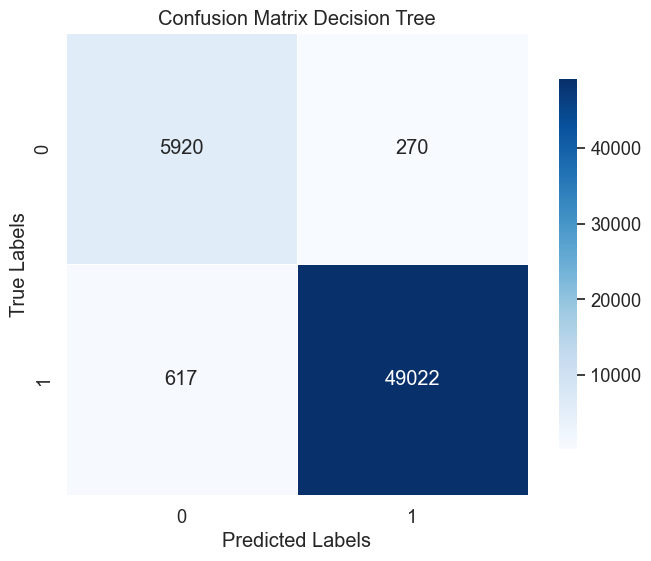

In [72]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_train_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar_kws={"shrink": 0.8}, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Decision Tree')
plt.savefig('Confusion Matrix Decision Tree.png', dpi=300)
plt.show()

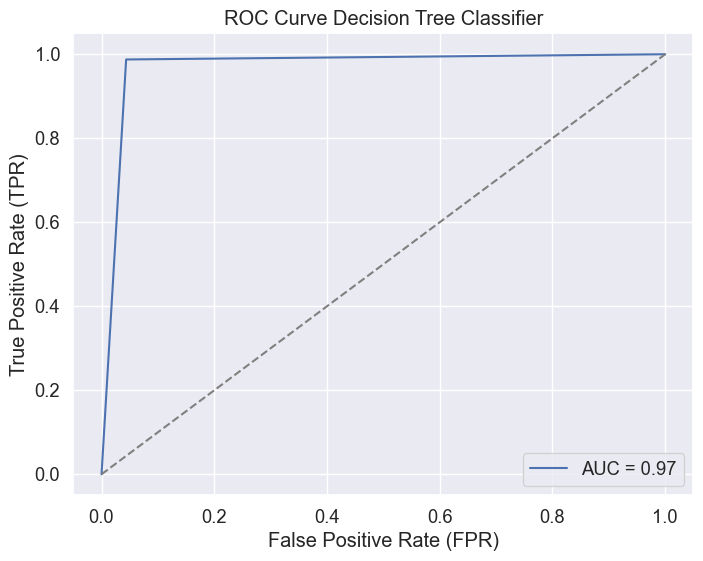

In [73]:
# Make predictions on the test set
y_scores = dt.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Decision Tree Classifier')
plt.legend()
plt.savefig('ROC Curve Decision Tree Classifier.png', dpi=300) 
plt.show()

## Decision Tree Classifier (Balanced Class)

In [74]:
dt_train_model_sliced=dt.predict(X_test_sliced_final)
# Calculate accuracy
accuracy = accuracy_score(y_test_sliced_final, dt_train_model_sliced)
print("Accuracy:", accuracy)

# Calculate the F1-score
f1 = f1_score(y_test_sliced_final, dt_train_model_sliced)
print("F1-Score:", f1)

#Classification Report
class_report = classification_report(y_test_sliced_final, dt_train_model_sliced)
print("Classification Report:")
print(class_report)

Accuracy: 0.97140549273021
F1-Score: 0.9718287442304632
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      6190
           1       0.96      0.99      0.97      6190

    accuracy                           0.97     12380
   macro avg       0.97      0.97      0.97     12380
weighted avg       0.97      0.97      0.97     12380



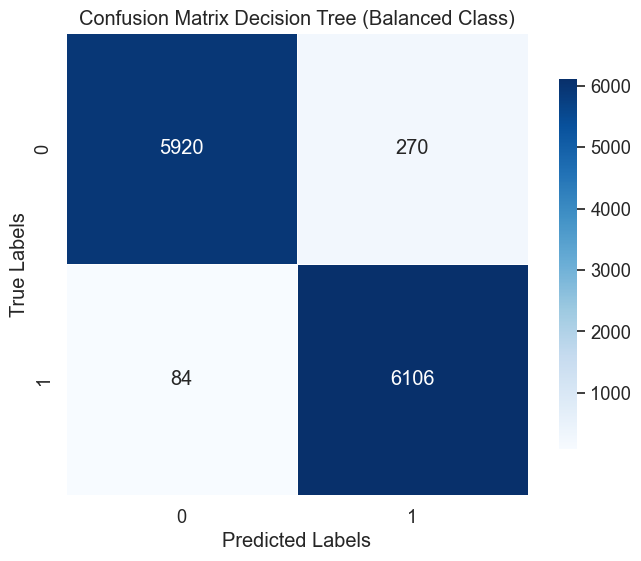

In [75]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_sliced_final, dt_train_model_sliced)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar_kws={"shrink": 0.8}, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Decision Tree (Balanced Class)')
plt.savefig('Confusion Matrix Decision Tree (Balanced Class).png', dpi=300) 
plt.show()

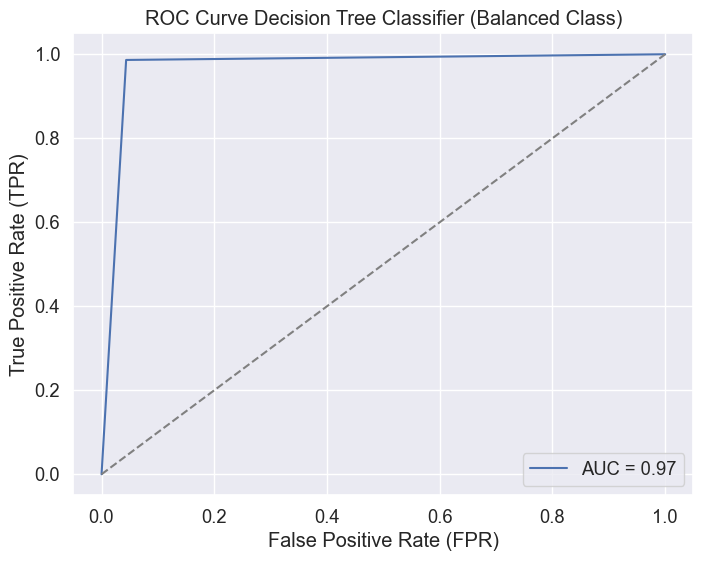

In [76]:
# Make predictions on the test set
y_scores = dt.predict_proba(X_test_sliced_final)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_sliced_final, y_scores)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test_sliced_final, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Decision Tree Classifier (Balanced Class)')
plt.legend()
plt.savefig('ROC Curve Decision Tree Classifier (Balanced Class).png', dpi=300)
plt.show()

## Random Forest Classifier

In [77]:
rf=RandomForestClassifier()
rf.fit(X_train_balanced,y_train_balanced)
rf_train_model=rf.predict(X_test)

In [78]:
# Calculate accuracy
accuracy = accuracy_score(y_test, rf_train_model)
print("Accuracy:", accuracy)

# Calculate the F1-score
f1 = f1_score(y_test, rf_train_model)
print("F1-Score:", f1)

#Classification Report
class_report = classification_report(y_test, rf_train_model)
print("Classification Report:")
print(class_report)

Accuracy: 0.9871034766877429
F1-Score: 0.9927090084251458
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6190
           1       1.00      0.99      0.99     49639

    accuracy                           0.99     55829
   macro avg       0.95      0.99      0.97     55829
weighted avg       0.99      0.99      0.99     55829



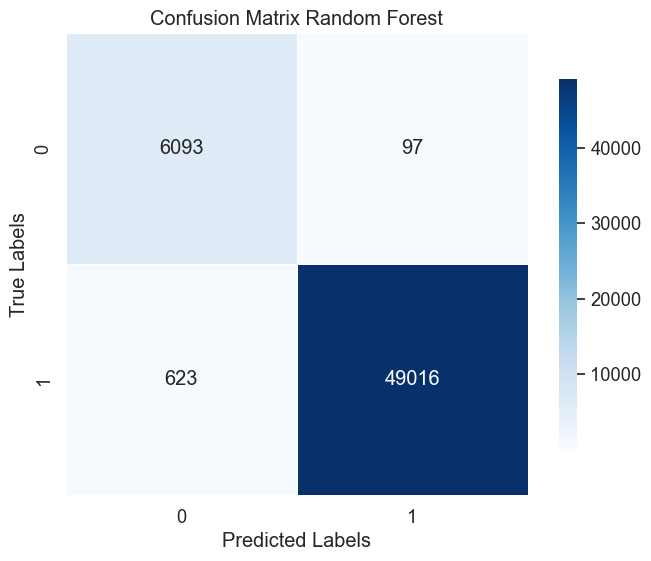

In [79]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_train_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar_kws={"shrink": 0.8}, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Random Forest')
plt.savefig('Confusion Matrix Random Forest.png', dpi=300) 
plt.show()

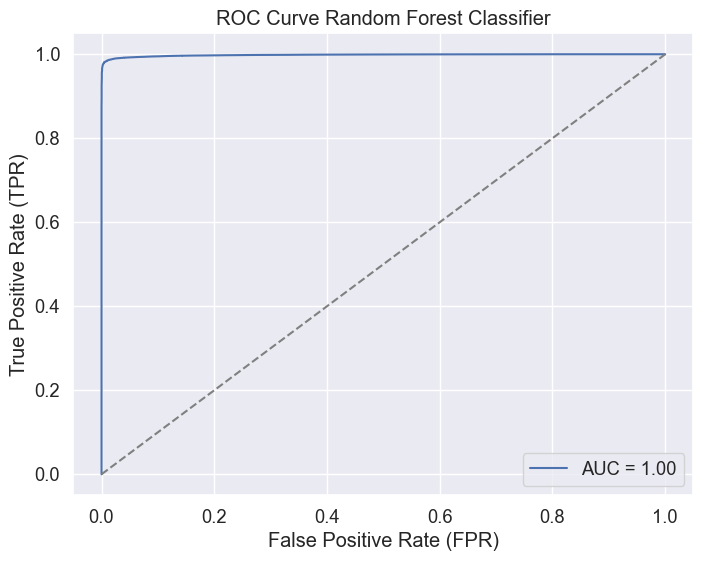

In [80]:
# Make predictions on the test set
y_scores = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Random Forest Classifier')
plt.legend()
plt.savefig('ROC Curve Random Forest Classifier.png', dpi=300) 
plt.show()

## Random Forest Classifier (Balanced Class)

In [81]:
rf_train_model_sliced=rf.predict(X_test_sliced_final)
# Calculate accuracy
accuracy = accuracy_score(y_test_sliced_final, rf_train_model_sliced)
print("Accuracy:", accuracy)

# Calculate the F1-score
f1 = f1_score(y_test_sliced_final, rf_train_model_sliced)
print("F1-Score:", f1)

#Classification Report
class_report = classification_report(y_test_sliced_final, rf_train_model_sliced)
print("Classification Report:")
print(class_report)

Accuracy: 0.9852180936995153
F1-Score: 0.9852312162053103
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      6190
           1       0.98      0.99      0.99      6190

    accuracy                           0.99     12380
   macro avg       0.99      0.99      0.99     12380
weighted avg       0.99      0.99      0.99     12380



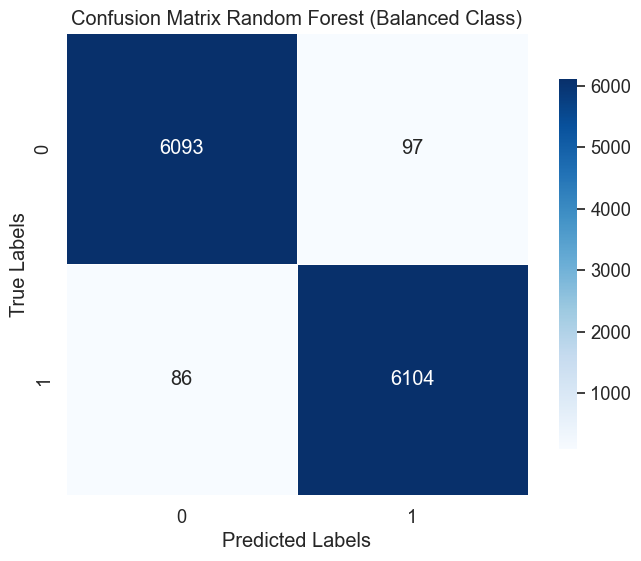

In [82]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_sliced_final, rf_train_model_sliced)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar_kws={"shrink": 0.8}, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Random Forest (Balanced Class)')
plt.savefig('Confusion Matrix Random Forest (Balanced Class).png', dpi=300)
plt.show()

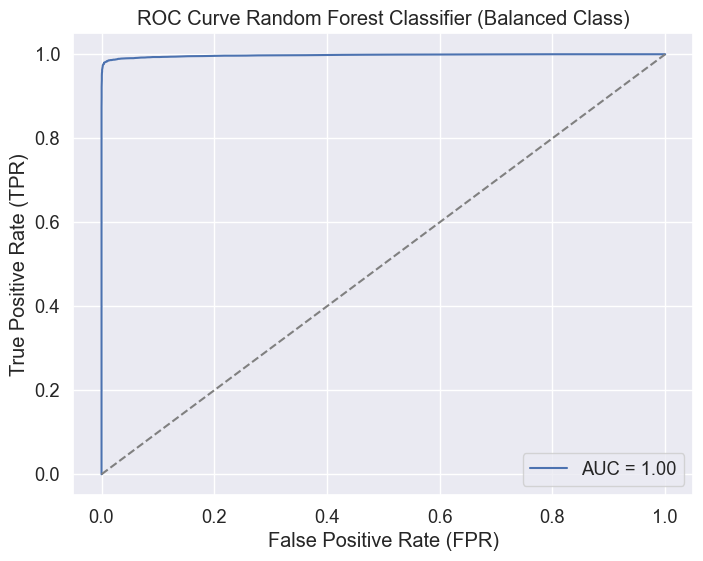

In [83]:
# Make predictions on the test set
y_scores = rf.predict_proba(X_test_sliced_final)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_sliced_final, y_scores)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test_sliced_final, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Random Forest Classifier (Balanced Class)')
plt.legend()
plt.savefig('ROC Curve Random Forest Classifier (Balanced Class)', dpi=300) 
plt.show()

## XGBoost Classifier

In [84]:
xg = XGBClassifier()
xg.fit(X_train_balanced, y_train_balanced)
xg_train_model = xg.predict(X_test)

In [85]:
# Calculate accuracy
accuracy = accuracy_score(y_test, xg_train_model)
print("Accuracy:", accuracy)

# Calculate the F1-score
f1 = f1_score(y_test, xg_train_model)

print("F1-Score:", f1)

class_report = classification_report(y_test, xg_train_model)
print("Classification Report:")
print(class_report)

Accuracy: 0.9873184187429472
F1-Score: 0.9928331376280519
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6190
           1       1.00      0.99      0.99     49639

    accuracy                           0.99     55829
   macro avg       0.95      0.99      0.97     55829
weighted avg       0.99      0.99      0.99     55829



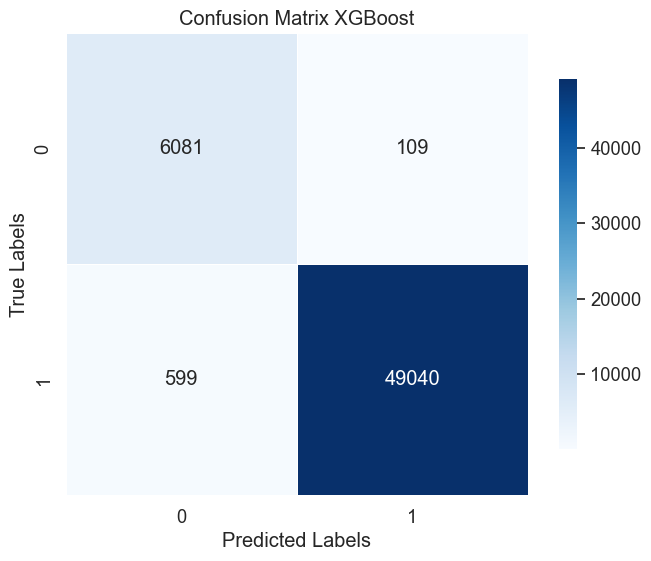

In [86]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, xg_train_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar_kws={"shrink": 0.8}, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBoost')
plt.savefig('Confusion Matrix XGBoost.png', dpi=300) 
plt.show()

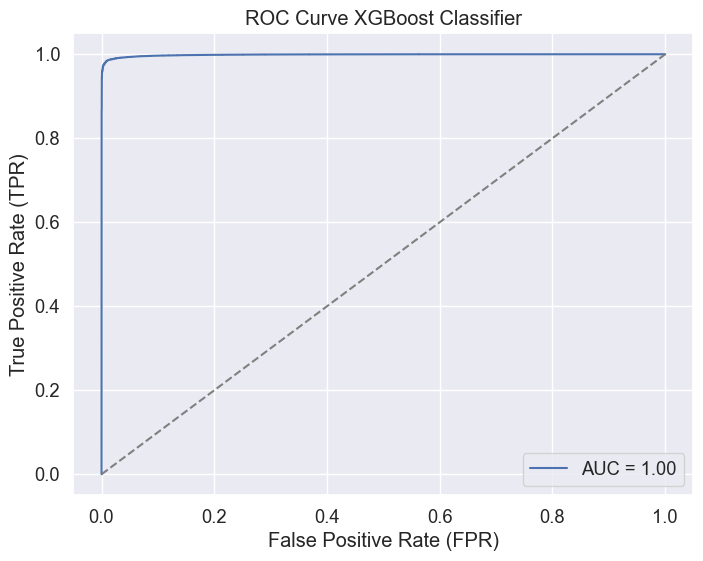

In [87]:
# Make predictions on the test set
y_scores = xg.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve XGBoost Classifier')
plt.legend()
plt.savefig('ROC Curve XGBoost Classifier.png', dpi=300) 
plt.show()

## XGBoost Classifier (Balanced Class)

In [88]:
xg_train_model_sliced=xg.predict(X_test_sliced_final)
# Calculate accuracy
accuracy = accuracy_score(y_test_sliced_final, xg_train_model_sliced)
print("Accuracy:", accuracy)

# Calculate the F1-score
f1 = f1_score(y_test_sliced_final, xg_train_model_sliced)
print("F1-Score:", f1)

#Classification Report
class_report = classification_report(y_test_sliced_final, xg_train_model_sliced)
print("Classification Report:")
print(class_report)

Accuracy: 0.984329563812601
F1-Score: 0.9843598839084167
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6190
           1       0.98      0.99      0.98      6190

    accuracy                           0.98     12380
   macro avg       0.98      0.98      0.98     12380
weighted avg       0.98      0.98      0.98     12380



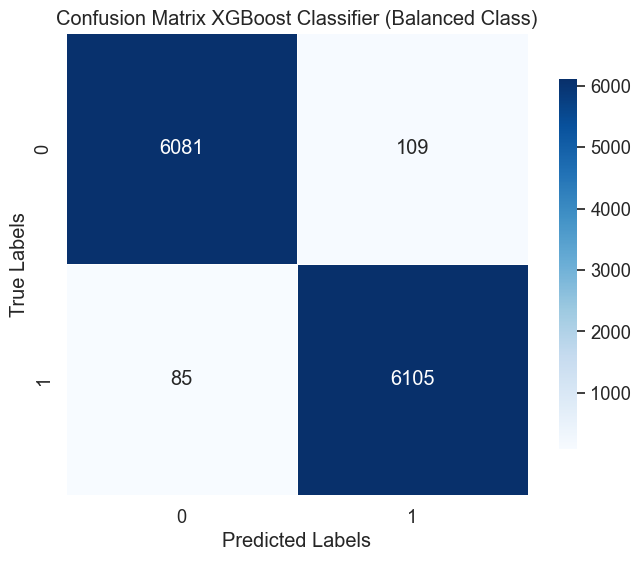

In [89]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_sliced_final, xg_train_model_sliced)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar_kws={"shrink": 0.8}, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix XGBoost Classifier (Balanced Class)')
plt.savefig('Confusion Matrix XGBoost Classifier (Balanced Class).png', dpi=300) 
plt.show()

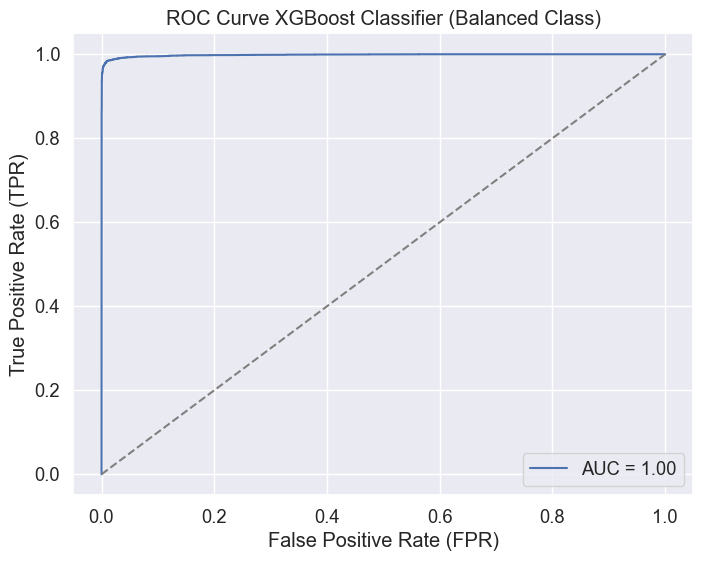

In [90]:
# Make predictions on the test set
y_scores = xg.predict_proba(X_test_sliced_final)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_sliced_final, y_scores)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test_sliced_final, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve XGBoost Classifier (Balanced Class)')
plt.legend()
plt.savefig('ROC Curve XGBoost Classifier (Balanced Class).png', dpi=300)
plt.show()